# Predicting a Distribution with an ML Model

In [12]:
import numpy as np
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt
from src.dataset import LazyWeatherDataset
from src.models import CNN3D
from src.loss import ShashNLL
from src.plotting import plot_distribution_heatmap
from torch.utils.data import DataLoader
import torch
import torch.nn as nn
import torch.optim as optim

Severe thunderstorms and their associated hazards (wind, hail, and tornados) are sub-gridscale processes. However, they are strongly associated with the synoptic weather pattern, which is identifiable in ERA5 fields. Predict the 

Task: Predict the number of storm reports on a given day in CONUS from that day's (thinned) ERA5 data

In [13]:
# load and display data
train_data = xr.open_zarr('data/train_inputs_small.zarr').load()
test_data = xr.open_zarr('data/test_inputs_small.zarr').load()

train_targets = xr.open_dataarray('data/mdt_reports_train.nc')
test_targets = xr.open_dataarray('data/mdt_reports_test.nc')


In [14]:
train_data # gridded weather data--note that it has alread been standardized and thinned in time/space

<xarray.Dataset>
Dimensions:                       (latitude: 16, longitude: 21, day: 332,
                                   tod: 4, level: 5)
Coordinates:
  * day                           (day) datetime64[ns] 2002-04-07 ... 2019-05-20
  * latitude                      (latitude) float32 45.0 44.0 ... 31.0 30.0
  * level                         (level) int64 925 850 700 500 300
  * longitude                     (longitude) float32 255.0 256.0 ... 275.0
  * tod                           (tod) int64 0 6 12 18
Data variables: (12/13)
    10m_u_component_of_wind       (latitude, longitude, day, tod) float32 0.4...
    10m_v_component_of_wind       (latitude, longitude, day, tod) float32 -1....
    2m_dewpoint_temperature       (latitude, longitude, day, tod) float32 -0....
    2m_temperature                (latitude, longitude, day, tod) float32 -0....
    geopotential                  (level, latitude, longitude, day, tod) float32 ...
    geopotential_at_surface       (latitude, longitude, day, tod) float32 1.3...
    ...                            ...
    specific_humidity             (level, latitude, longitude, day, tod) float32 ...
    temperature                   (level, latitude, longitude, day, tod) float32 ...
    toa_incident_solar_radiation  (latitude, longitude, day, tod) float32 0.2...
    u_component_of_wind           (level, latitude, longitude, day, tod) float32 ...
    v_component_of_wind           (level, latitude, longitude, day, tod) float32 ...
    vertical_velocity             (level, latitude, longitude, day, tod) float32 ...

In [15]:
train_targets # Number of storm reports on each day

<xarray.DataArray 'REPORT_NUM' (time: 332)>
[332 values with dtype=int32]
Coordinates:
  * time     (time) datetime64[ns] 2002-04-07 2002-04-13 ... 2019-05-20

Note the skewed distribution:

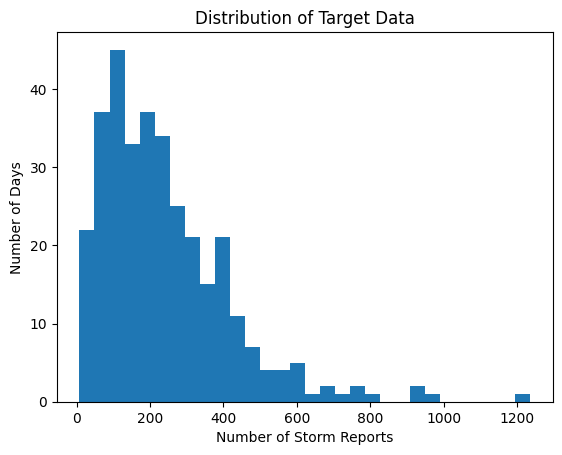

In [16]:
plt.hist(train_targets, bins = 30)
plt.xlabel('Number of Storm Reports')
plt.ylabel('Number of Days')
plt.title('Distribution of Target Data')
plt.show()

In [17]:
# We standardize the targets for stability--don't worry about this
training_mean = np.mean(train_targets).item()
training_std = np.std(train_targets).item()
train_targets = (train_targets - training_mean) / training_std
test_targets = (test_targets - training_mean) / training_std

## Setup

In [18]:
# setup
batch_size = 32

train_ds = LazyWeatherDataset(train_data, y=train_targets)
test_ds = LazyWeatherDataset(test_data, y=test_targets)

train_loader = DataLoader(train_ds, batch_size=batch_size)
test_loader = DataLoader(test_ds, batch_size=1)

## Traditional Regression CNN

In [19]:
train_ds[0][0].shape

torch.Size([41, 16, 21, 4])

In [20]:
train_ds[0][0].shape[0], train_ds[0][1].shape[0]

(41, 1)

Question: What do 41 and 1 represent?

Answer: 

### Specify Model

In [21]:
model = CNN3D(input_channels=train_ds[0][0].shape[0], output_dim=train_ds[0][1].shape[0], p_drop_conv=.3, p_drop_fc=.3)

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

### Train Model

In [22]:
# show regression model performance
epochs = 20

train_losses = []
val_losses = []

for epoch in range(epochs):
    model.train()
    train_loss = 0
    for x, y in train_loader:
        optimizer.zero_grad()
        preds = model(x)
        loss = criterion(preds, y)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * x.size(0)

    avg_train_loss = train_loss / len(train_loader.dataset)
    train_losses.append(avg_train_loss)

    # Validation
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for x, y in test_loader:
            preds = model(x)
            loss = criterion(preds, y)
            val_loss += loss.item() * x.size(0)

    avg_val_loss = val_loss / len(test_loader.dataset)
    val_losses.append(avg_val_loss)

    print(f"Epoch {epoch+1}/{epochs} - Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}")

Epoch 1/20 - Train Loss: 0.9899, Val Loss: 1.6341
Epoch 2/20 - Train Loss: 0.9286, Val Loss: 1.3397
Epoch 3/20 - Train Loss: 0.8694, Val Loss: 1.5604
Epoch 4/20 - Train Loss: 0.8376, Val Loss: 1.6178
Epoch 5/20 - Train Loss: 0.8423, Val Loss: 1.5189
Epoch 6/20 - Train Loss: 0.8089, Val Loss: 1.5530
Epoch 7/20 - Train Loss: 0.7447, Val Loss: 1.5607
Epoch 8/20 - Train Loss: 0.7607, Val Loss: 1.5206
Epoch 9/20 - Train Loss: 0.7235, Val Loss: 1.5480
Epoch 10/20 - Train Loss: 0.7425, Val Loss: 1.4950
Epoch 11/20 - Train Loss: 0.7702, Val Loss: 1.6596
Epoch 12/20 - Train Loss: 0.7553, Val Loss: 1.5377
Epoch 13/20 - Train Loss: 0.7062, Val Loss: 1.5506
Epoch 14/20 - Train Loss: 0.6952, Val Loss: 1.5455
Epoch 15/20 - Train Loss: 0.6770, Val Loss: 1.5811
Epoch 16/20 - Train Loss: 0.6863, Val Loss: 1.5916
Epoch 17/20 - Train Loss: 0.7123, Val Loss: 1.6542
Epoch 18/20 - Train Loss: 0.6350, Val Loss: 1.5637
Epoch 19/20 - Train Loss: 0.6488, Val Loss: 1.5229
Epoch 20/20 - Train Loss: 0.6592, Val Lo

### Display Results

Training curve and 2dhistogram of predictions vs actual

Text(0.5, 1.0, 'Training and Validation Curves')

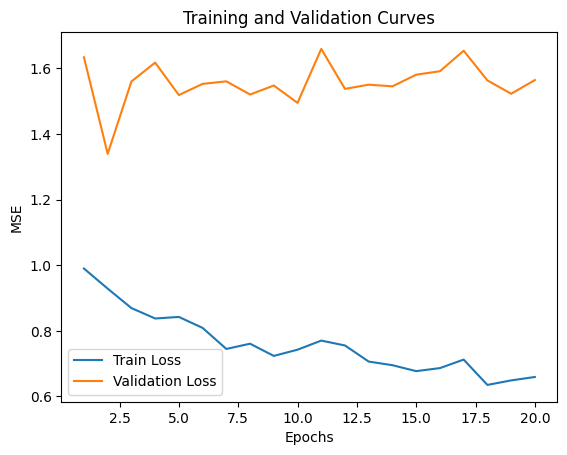

In [23]:
plt.plot(range(1, epochs+1), train_losses, label='Train Loss')
plt.plot(range(1, epochs+1), val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('MSE')
plt.legend()
plt.title('Training and Validation Curves')

Text(0, 0.5, 'Predicted Values')

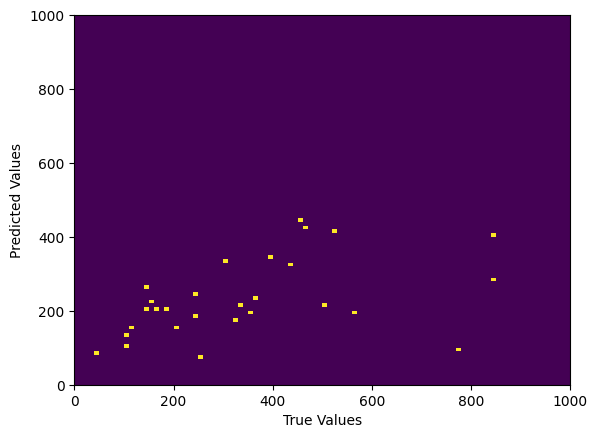

In [24]:
# make 2d historgam of test predictions vs actual
preds = []
true = []
for x, y in test_loader:
    preds.append(model(x).item() * training_std + training_mean)
    true.append(y.item() * training_std + training_mean)
plt.hist2d(true, preds, bins=100, range=[[0, 1000], [0, 1000]])
plt.xlabel('True Values')
plt.ylabel('Predicted Values')


Question: What do you notice about the predicted values?

Answer: 

## Gaussian Distributional CNN

### Specify Model

In [ ]:
input_channels = # TODO
output_dim = # TODO
model = CNN3D(input_channels=input_channels, output_dim=output_dim, p_drop_conv=.3, p_drop_fc=.3)

def gaussian_nll(input, target, var):
    """
    Custom Gaussian NLL that matches nn.GaussianNLLLoss.
    input: predicted mean (batch, ...)
    target: true values (batch, ...)
    var: predicted variance (batch, ...)
    """
    # TODO: Implement
    return
criterion = gaussian_nll

# uncomment the following line to use the built-in implementation for verification:
# criterion = nn.GaussianNLLLoss()

optimizer = optim.Adam(model.parameters(), lr=1e-3)

### Train Model

In [ ]:
# show regression model performance
epochs = 20

train_losses = []
val_losses = []

for epoch in range(epochs):
    model.train()
    train_loss = 0
    for x, y in train_loader:
        optimizer.zero_grad()
        preds = model(x)

        # TODO: HOW DO WE GET LOSS?
        # hint: use preds[:, 0] as the mean, and preds[:, 1] as the log(variance) (it could be just the variance, but predicting log(variance) ensures positivity)
        # then call gaussian_nll()
        
        loss = 

        loss.backward()
        optimizer.step()
        train_loss += loss.item() * x.size(0)

    avg_train_loss = train_loss / len(train_loader.dataset)
    train_losses.append(avg_train_loss)

    # Validation
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for x, y in test_loader:
            preds = model(x)

            # TODO: AGAIN, HOW DO WE GET LOSS?
            
            loss = 
            
            val_loss += loss.item() * x.size(0)

    avg_val_loss = val_loss / len(test_loader.dataset)
    val_losses.append(avg_val_loss)

    print(f"Epoch {epoch+1}/{epochs} - Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}")

Epoch 1/20 - Train Loss: 0.5936, Val Loss: 1.0773
Epoch 2/20 - Train Loss: 0.5689, Val Loss: 1.0644
Epoch 3/20 - Train Loss: 0.5600, Val Loss: 0.9777
Epoch 4/20 - Train Loss: 0.5368, Val Loss: 0.9702
Epoch 5/20 - Train Loss: 0.5273, Val Loss: 0.9635
Epoch 6/20 - Train Loss: 0.5153, Val Loss: 1.0268
Epoch 7/20 - Train Loss: 0.5181, Val Loss: 0.9717
Epoch 8/20 - Train Loss: 0.5156, Val Loss: 0.9549
Epoch 9/20 - Train Loss: 0.5134, Val Loss: 0.9538
Epoch 10/20 - Train Loss: 0.5190, Val Loss: 0.9393
Epoch 11/20 - Train Loss: 0.5100, Val Loss: 0.9626
Epoch 12/20 - Train Loss: 0.5129, Val Loss: 0.9299
Epoch 13/20 - Train Loss: 0.5145, Val Loss: 0.9458
Epoch 14/20 - Train Loss: 0.5194, Val Loss: 0.9273
Epoch 15/20 - Train Loss: 0.5075, Val Loss: 0.9426
Epoch 16/20 - Train Loss: 0.5075, Val Loss: 0.9530
Epoch 17/20 - Train Loss: 0.5067, Val Loss: 0.9225
Epoch 18/20 - Train Loss: 0.5026, Val Loss: 0.9099
Epoch 19/20 - Train Loss: 0.5048, Val Loss: 0.9069
Epoch 20/20 - Train Loss: 0.5021, Val Lo

### Display Results

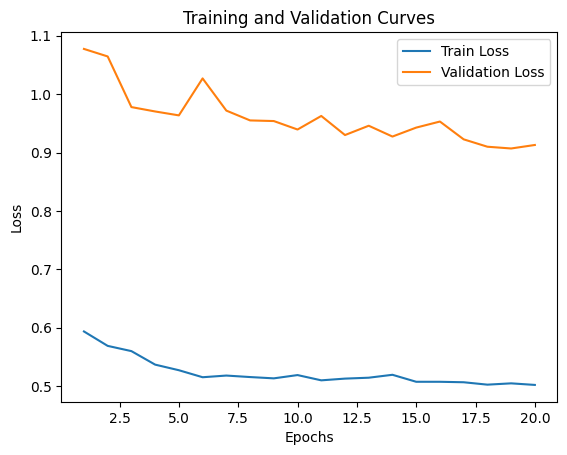

In [27]:
plt.plot(range(1, epochs+1), train_losses, label='Train Loss')
plt.plot(range(1, epochs+1), val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Curves')
plt.show()

In [28]:
means = []
variances = []
true = []
for x, y in test_loader:
    means.append(model(x)[0][0].item() * training_std + training_mean)
    variances.append(model(x)[0][1].item())
    true.append(y.item() * training_std + training_mean)

gaussian_means = torch.tensor(means, dtype=torch.float32)
gaussian_variances = torch.tensor(variances, dtype=torch.float32)
gaussian_true = torch.tensor(true, dtype=torch.float32)

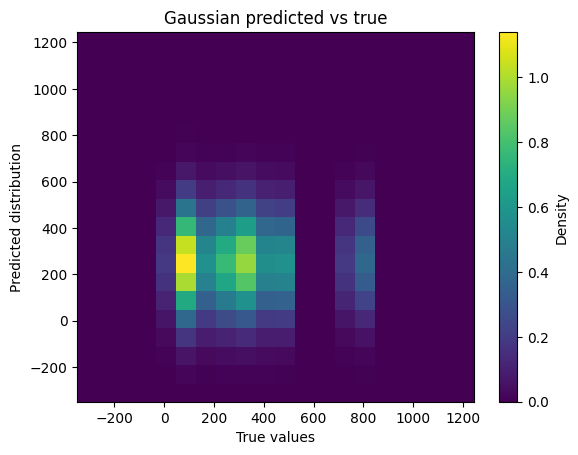

In [29]:
plot_distribution_heatmap(gaussian_true, gaussian_means, logvar=gaussian_variances, dist="gaussian", training_std = training_std, margin = .5, bins = 20)

Question: What is a flaw in the predictions?

Answer:

## SHASH Distributional CNN

### Specify Model

In [ ]:
# use shash_torch.py and loss.py from barnes
input_channels = # TODO
output_dim = # TODO

model = CNN3D(input_channels=input_channels, output_dim=output_dim, p_drop_conv=.3, p_drop_fc=.3)

criterion = # TODO (you don't need to implement anything--we've imported something)

optimizer = optim.Adam(model.parameters(), lr=1e-3)

In [31]:
def unpack_shash_params(preds):
    """
    preds: (batch, output_dim=4) tensor
    Returns: mu, sigma, gamma, tau
    """
    mu     = preds[:, 0]             # unconstrained
    sigma  = torch.exp(preds[:, 1])  # force > 0
    gamma  = preds[:, 2]             # unconstrained--add one to have model learn starting from 1 since we expect postive gamma
    tau    = torch.exp(preds[:, 3])  # force > 0
    return torch.stack([mu, sigma, gamma, tau], dim=1)

### Train Model

In [ ]:
# show regression model performance
epochs = 50

train_losses = []
val_losses = []

for epoch in range(epochs):
    model.train()
    train_loss = 0
    for x, y in train_loader:
        optimizer.zero_grad()
        preds = model(x)
        preds = unpack_shash_params(preds)
        
        loss = criterion(preds, y)

        loss.backward()
        optimizer.step()
        train_loss += loss.item() * x.size(0)

    avg_train_loss = train_loss / len(train_loader.dataset)
    train_losses.append(avg_train_loss)

    # Validation
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for x, y in test_loader:
            preds = model(x)
            preds = unpack_shash_params(preds)

            loss = criterion(preds, y)

            val_loss += loss.item() * x.size(0)

    avg_val_loss = val_loss / len(test_loader.dataset)
    val_losses.append(avg_val_loss)

    print(f"Epoch {epoch+1}/{epochs} - Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}")

Epoch 1/50 - Train Loss: 1.7718, Val Loss: 1.8058
Epoch 2/50 - Train Loss: 1.7589, Val Loss: 1.7655
Epoch 3/50 - Train Loss: 1.6312, Val Loss: 1.8489
Epoch 4/50 - Train Loss: 1.5825, Val Loss: 1.7143
Epoch 5/50 - Train Loss: 1.5221, Val Loss: 1.7532
Epoch 6/50 - Train Loss: 1.5155, Val Loss: 1.6930
Epoch 7/50 - Train Loss: 1.4864, Val Loss: 1.8790
Epoch 8/50 - Train Loss: 1.4670, Val Loss: 1.6885
Epoch 9/50 - Train Loss: 1.4592, Val Loss: 1.6362
Epoch 10/50 - Train Loss: 1.4421, Val Loss: 1.6640
Epoch 11/50 - Train Loss: 1.4347, Val Loss: 1.6404
Epoch 12/50 - Train Loss: 1.4267, Val Loss: 1.6589
Epoch 13/50 - Train Loss: 1.4108, Val Loss: 1.6329
Epoch 14/50 - Train Loss: 1.4043, Val Loss: 1.6108
Epoch 15/50 - Train Loss: 1.4047, Val Loss: 1.6325
Epoch 16/50 - Train Loss: 1.3942, Val Loss: 1.6454
Epoch 17/50 - Train Loss: 1.3770, Val Loss: 1.6232
Epoch 18/50 - Train Loss: 1.3811, Val Loss: 1.6129
Epoch 19/50 - Train Loss: 1.3723, Val Loss: 1.6034
Epoch 20/50 - Train Loss: 1.3675, Val Lo

### Display Results

Text(0.5, 1.0, 'Training and Validation Curves')

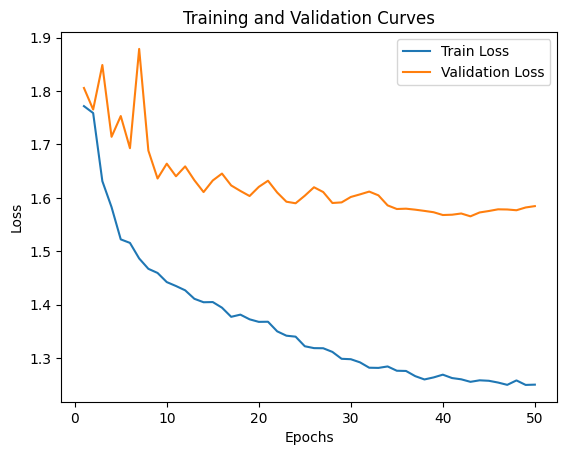

In [33]:
plt.plot(range(1, epochs+1), train_losses, label='Train Loss')
plt.plot(range(1, epochs+1), val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Curves')

In [34]:
mus = []
sigmas = []
gammas = []
taus = []
true = []
for x, y in test_loader:
    mus.append(model(x)[0][0].item() * training_std + training_mean)
    sigmas.append(np.exp(model(x)[0][1].item()) * training_std)
    gammas.append(model(x)[0][2].item())
    taus.append(np.exp(model(x)[0][3].item()))
    true.append(y.item() * training_std + training_mean)

shash_mus = torch.tensor(mus, dtype=torch.float32)
shash_sigmas = torch.tensor(sigmas, dtype=torch.float32)
shash_gammas = torch.tensor(gammas, dtype=torch.float32)
shash_taus = torch.tensor(taus, dtype=torch.float32)
shash_true = torch.tensor(true, dtype=torch.float32)

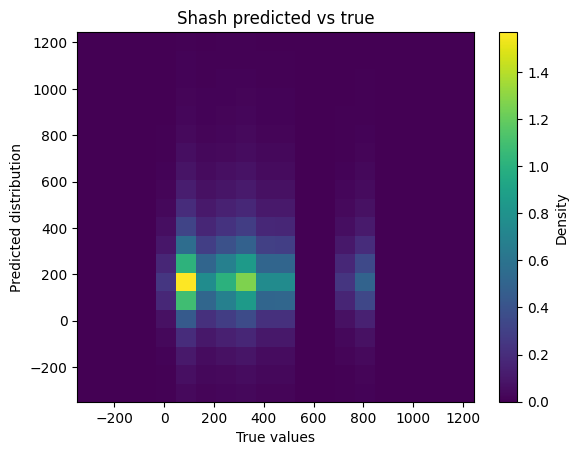

In [35]:
plot_distribution_heatmap(shash_true, shash_mus,
                          sigma=shash_sigmas, gamma=shash_gammas, tau=shash_taus,
                          dist="shash", bins = 20, margin = .5)

Question: How does this look compared to the Gaussian?

Answer: